# LightGBM Code Tutorial

<b><u>[목적]</u></b>
- 이전 모델에서는 Missing Value 값들을 전부 삭제하고 진행함
- LightGBM의 경우 Missing Value를 모델 자체 내에서 처리해주기 때문에 삭제하지 않음
- 현재는 충분한 데이터가 있기 때문에 Missing Value를 전부 삭제해도 무관함
- 빅데이터를 빠르게 수행함

<b><u>[Process]</u></b>
- Data Path = 'https://github.com/GonieAhn/Data-Science-online-course-from-gonie/tree/main/Data%20Store'
- Define X's & Y
- Transform Y (Numeric --> Category)
- Split Train & Valid data set
- Modeling
- 해석

<b><u>[주의]</u></b>
- Tutorial Code가 있는 폴더에 "LightGBM_model"라는 폴더를 만들어줘야함 (모델 저장)
- 생성한 폴더에 Hyperparameter를 Tuning 하면서 모델을 모두 저장함
- 논문에서는 데이터 10,000개 이상일 때 사용하라고 했지만, 일단 돌려보자

In [1]:
import os
import gc
import re
import pickle
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter

In [2]:
%%time
# Data Load 
data = pd.read_csv("../Data Store/TOY_DATA.csv")
data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (3500, 355)
Wall time: 224 ms


<b><u>[Data Condition Check]</u></b>
- Data Condition
    - 그 전 Tutorial에서는 Missing Value에 대한 Row를 모두 삭제함
    - 이번에는 살려둠
    - 변수는 Missing Percentage와 Level(Unique) 값에 따라 삭제함

In [3]:
 # Feature Name Cleaning
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

In [4]:
# Data Checking
col = []
missing = []
level = [] 
for name in data.columns:
    
    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']), 
                     pd.DataFrame(missing, columns=['Missing Percentage']), 
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (3500, 345)


In [5]:
drop_col

57      X57
59      X59
108    X108
114    X114
132    X132
140    X140
151    X151
344    X344
353    X353
354    X354
Name: name, dtype: object

<b><u>[Change Regression P to Classification P]</u></b>
- Data Cleaning 진행
- Regression Problem ==> Classification Problem 상위 30% [Class 1]과 하위 30% [Class 0]
    - 이렇게 하는 이유는 결국 우리는 상위 n%와 하위 n%의 차이를 알고 싶은 것
    - 복잡한 Regression 문제보다 1 또는 0을 마추는 Classification Problem으로 전환해보자
    - 그리고 상위 n%가 나오는 Rule을 도출해보자 (해석력을 얻기 위함)
    - 이렇게 할 경우 데이터 손실이 있기 때문에 데이터가 많은 경우 써먹어보자

In [6]:
per_70 = np.percentile(data['Y'], 70)
per_30 = np.percentile(data['Y'], 30)
print(">>>> 70 Percentile : {}".format(per_70))
print(">>>> 30 Percentile : {}".format(per_30))

>>>> 70 Percentile : 0.821760391
>>>> 30 Percentile : 0.7269621028


In [7]:
data = data[(data['Y'] >= per_70) | (data['Y'] <= per_30)]
data.reset_index(inplace=True, drop=True)
print('Data shape : {}'.format(data.shape))

Data shape : (2101, 345)


In [8]:
data['Label'] = 3
data['Label'].iloc[np.where(data['Y'] >= per_70)[0]] = 1
data['Label'].iloc[np.where(data['Y'] <= per_30)[0]] = 0
print("Unique Label : {}".format(set(data['Label'])))

Unique Label : {0, 1}


In [9]:
Counter(data['Label'])

Counter({1: 1051, 0: 1050})

In [10]:
# X1, X2, X3는 Y에 영향을 너무 많이 미치는 변수이기 때문에 빼고 다른 변수에서 중요도를 찾아보자
Y = data['Label']
X = data.drop(columns=['Y', 'X1', 'X2', 'X3', 'Label'])

In [11]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))

>>>> # of Train data : 1470
>>>> # of valid data : 631


<b><u>[LightGBM]</u></b>
- Hyperparameter tuning
    - n_estimators, learning_rate, max_depth, reg_alpha
    - LightGBM은 Hyperparam이 굉장히 많은 알고리즘 중에 하나임
    - 위에 4가지만 잘 조정해도 좋은 결과를 얻을 수 있음
    - 내가 많이 해봤음

In [13]:
# Parameter Tuning - Reference : https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# n_estimators
n_tree = [50, 70, 100]
# learning_rate
l_rate = [0.1, 0.5]
# max_depth
m_depth = [10, 20]
# reg_alpha
L1_norm = [0.1, 1]

# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
save_acc = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:
                
                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = LGBMClassifier(n_estimators=n, learning_rate=l, 
                                       max_depth=m, reg_alpha=L1, 
                                       n_jobs=-1, objective='binary')
                model.fit(X.iloc[train_idx], Y.iloc[train_idx])
                
                
                # Train Acc
                y_pre_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))

                # Test Acc
                y_pre_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                save_acc.append((cm_test[0,0] + cm_test[1,1])/cm_test.sum())
                
                joblib.dump(model, './LightGBM_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(save_acc[-1], 4)))
                gc.collect()

>>> 0 <<<
n_estimators : 50, learning_rate : 0.1, max_depth : 10, reg_alpha : 0.1
Train Confusion Matrix
[[740   0]
 [  0 730]]
Train Acc : 1.0
Test Confusion Matrix
[[220  90]
 [ 52 269]]
TesT Acc : 0.7749603803486529
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 50, learning_rate : 0.1, max_depth : 10, reg_alpha : 1
Train Confusion Matrix
[[738   2]
 [  3 727]]
Train Acc : 0.9965986394557823
Test Confusion Matrix
[[226  84]
 [ 47 274]]
TesT Acc : 0.7923930269413629
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 50, learning_rate : 0.1, max_depth : 20, reg_alpha : 0.1
Train Confusion Matrix
[[740   0]
 [  0 730]]
Train Acc : 1.0
Test Confusion Matrix
[[219  91]
 [ 49 272]]
TesT Acc : 0.7781299524564184
------------------------------------------

In [14]:
# Best Param
print(">>> {} <<<\nBest Test Acc : {}\nBest n_estimators : {}\nBest Learning Rate : {}\nBest Max_Depth : {}\nBest L1-norm term : {}".format(np.argmax(save_acc),
                                                                                                                                            save_acc[np.argmax(save_acc)], 
                                                                                                                                            save_n[np.argmax(save_acc)],
                                                                                                                                            save_l[np.argmax(save_acc)],
                                                                                                                                            save_m[np.argmax(save_acc)],
                                                                                                                                            save_L1[np.argmax(save_acc)]))

>>> 1 <<<
Best Test Acc : 0.7923930269413629
Best n_estimators : 50
Best Learning Rate : 0.1
Best Max_Depth : 10
Best L1-norm term : 1


In [16]:
# Best Model Loading
model = joblib.load("./LightGBM_model/Result_{}_{}_{}_{}_{}.pkl".format(save_n[np.argmax(save_acc)],
                                                                       save_l[np.argmax(save_acc)],
                                                                       save_m[np.argmax(save_acc)],
                                                                       save_L1[np.argmax(save_acc)],
                                                                       round(save_acc[np.argmax(save_acc)], 4))) 

In [17]:
feature_map = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])[:20]
print(feature_map)

    Score Feature
0      99     X23
1      42     X22
2      27    X258
3      27    X253
4      25    X259
5      24    X223
6      21     X71
7      21    X261
8      21    X254
9      21    X110
10     20    X275
11     20    X267
12     19    X280
13     19     X18
14     18     X16
15     17    X200
16     17    X195
17     16     X30
18     16    X155
19     15    X222


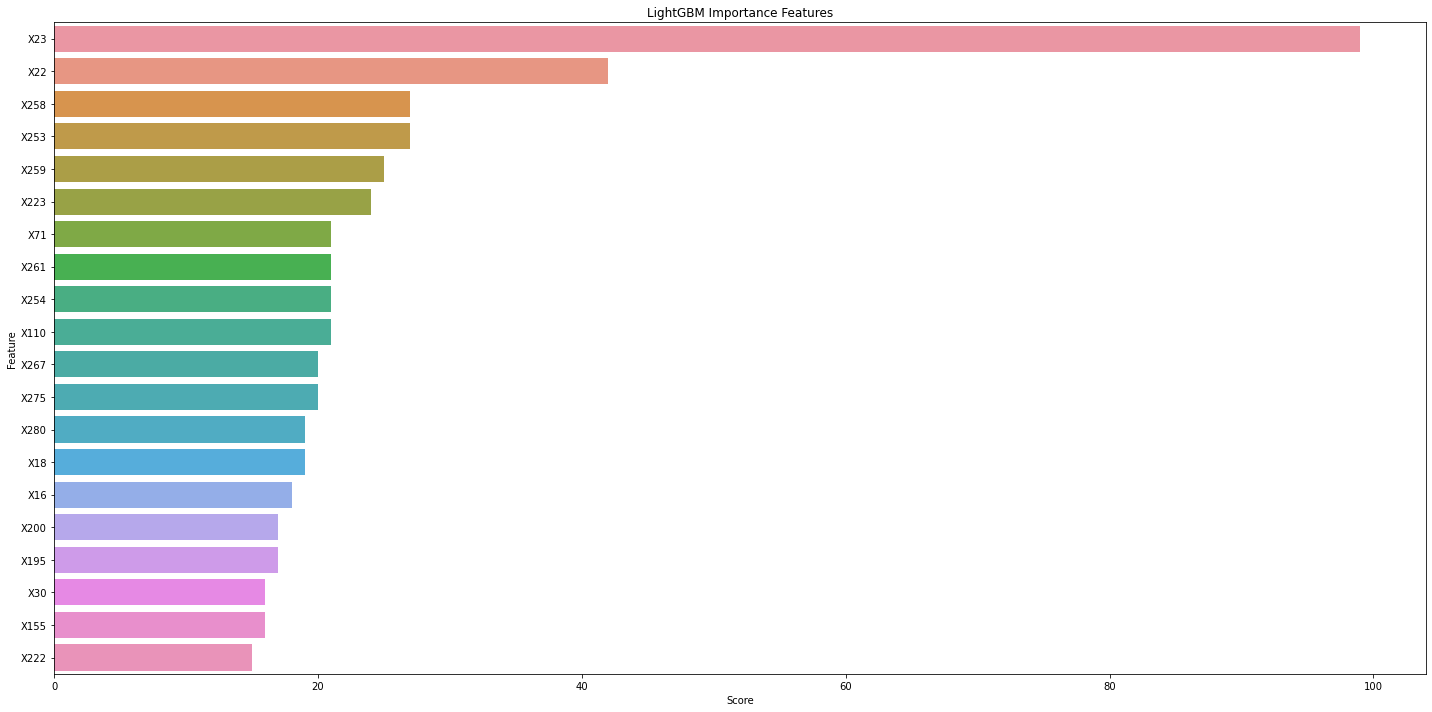

In [18]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('LightGBM Importance Features')
plt.tight_layout()
plt.show()